In [72]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn import preprocessing
from IPython.core.pylabtools import figsize
import xgboost as xgb
%matplotlib inline

from os import path
to_filename = lambda name: path.join("..", "data", "allstate", name +".csv")

In [2]:
train = pd.read_csv(to_filename("train"), index_col=0)
test = pd.read_csv(to_filename("test"), index_col=0)
print("shape: train {}, test {}".format(train.shape, test.shape))
print(train.head(2))

shape: train (188318, 131), test (125546, 130)
   cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9 cat10   ...        cont6  \
id                                                      ...                
1     A    B    A    B    A    A    A    A    B     A   ...     0.718367   
2     A    B    A    A    A    A    A    A    B     B   ...     0.438917   

       cont7    cont8    cont9   cont10    cont11    cont12    cont13  \
id                                                                      
1   0.335060  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493   
2   0.436585  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431   

      cont14     loss  
id                     
1   0.714843  2213.18  
2   0.304496  1283.60  

[2 rows x 131 columns]


In [3]:
cat_features = [col for col in train.columns if col.startswith("cat")]
print("Categorical columns:", cat_features)

('Categorical columns:', ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'c

In [4]:
# Encode the labels to int
for col in cat_features:
    encd = preprocessing.LabelEncoder()
    encd.fit(train[col].value_counts().index.union(test[col].value_counts().index))
    train[col] = encd.transform(train[col])
    test[col] = encd.transform(test[col])

In [39]:
dtrain = xgb.DMatrix(train.drop("loss", 1), train.loss)

In [158]:
params = {'objective':"reg:linear", 'silent': True, 'max_depth': 7, 'min_child_weight': 1,
          'colsample_bytree': 0.8, 'eta': 0.4, 'eval_metric':'mae', "n_estimators": 20,
          "gamma": 0.}

In [159]:
cvresult = xgb.cv(params, dtrain, nfold=4)
print(cvresult)

   test-mae-mean  test-mae-std  train-mae-mean  train-mae-std
0    1905.146942     11.911403     1903.169373       2.531280
1    1463.320434      5.301255     1456.685700       4.896339
2    1323.008972      4.868719     1309.430877       3.010983
3    1279.792847      4.003689     1260.996765       2.606099
4    1262.872345      3.497885     1238.884644       1.498404
5    1257.204712      1.176175     1228.336701       2.173101
6    1252.748505      1.938202     1220.486236       1.273407
7    1248.768250      2.299182     1213.167877       1.486372
8    1243.935821      1.428109     1204.304962       1.094887
9    1239.051422      1.339732     1196.252471       2.455023


In [160]:
print("optimum number of trees required", cvresult.shape[0])
params["n_estimators"] = cvresult.shape[0]

('optimum number of trees required', 10)


In [161]:
pred_test = 0.
num_runs = 1
for i in range(num_runs):
    params['seed'] = i
    clf = xgb.train(params, dtrain, num_boost_round=50, evals=[(dtrain, "train")])
    dtest = xgb.DMatrix(test)
    pred_test += clf.predict(dtest)

[0]	train-mae:1900.89
[1]	train-mae:1458.82
[2]	train-mae:1322.05
[3]	train-mae:1272.51
[4]	train-mae:1246.57
[5]	train-mae:1232.09
[6]	train-mae:1222.63
[7]	train-mae:1217.42
[8]	train-mae:1208.95
[9]	train-mae:1201.34
[10]	train-mae:1193.9
[11]	train-mae:1187.89
[12]	train-mae:1181.57
[13]	train-mae:1175.29
[14]	train-mae:1170.6
[15]	train-mae:1167.34
[16]	train-mae:1163.03
[17]	train-mae:1159.51
[18]	train-mae:1156.39
[19]	train-mae:1153.22
[20]	train-mae:1151.39
[21]	train-mae:1150.11
[22]	train-mae:1146.04
[23]	train-mae:1142.72
[24]	train-mae:1140.61
[25]	train-mae:1138.87
[26]	train-mae:1136.79
[27]	train-mae:1134
[28]	train-mae:1132.51
[29]	train-mae:1130.02
[30]	train-mae:1128.57
[31]	train-mae:1125.81
[32]	train-mae:1123.47
[33]	train-mae:1122.15
[34]	train-mae:1120.38
[35]	train-mae:1118.84
[36]	train-mae:1117.46
[37]	train-mae:1115.57
[38]	train-mae:1114.5
[39]	train-mae:1113.57
[40]	train-mae:1112.79
[41]	train-mae:1111.16
[42]	train-mae:1109.13
[43]	train-mae:1107.32
[44]

In [163]:
import datetime
result = pd.DataFrame({"id": test.index, "loss": pred_test / num_runs})
result.to_csv("result{:%Y%m%d%H}.csv".format(datetime.datetime.now()), index=None)

# Using XGBRegressor and important features

In [50]:
from sklearn.grid_search import GridSearchCV
from xgboost import XGBRegressor

In [62]:
params_reg = dict(params)
params_reg.pop("eta")
params_reg.pop('eval_metric')

'mae'

In [63]:
params["n_estimators"] = cvresult.shape[0]
reg = XGBRegressor(**params_reg)
reg.fit(train.drop("loss", 1), train.loss)

XGBRegressor(base_score=0.1, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=10, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=True, subsample=1)

In [65]:
train_predprob = reg.score

In [69]:
reg_booster = reg.booster()

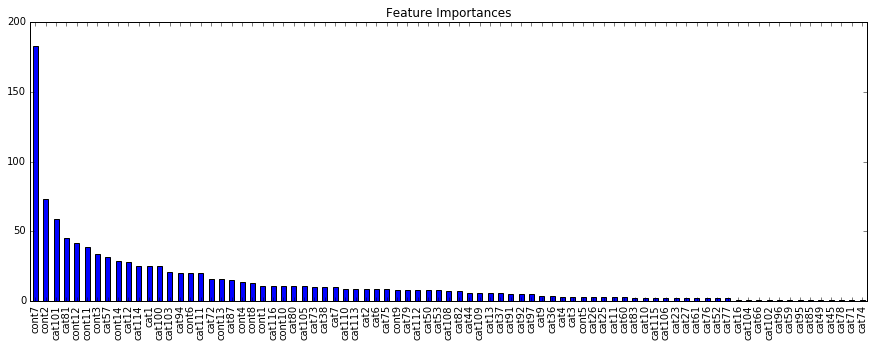

In [73]:
figsize(15, 5)
feat_imp = pd.Series(reg.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

In [76]:
important_features = list(feat_imp[feat_imp > 10].index)
print("important features:", important_features)

('important features:', ['cont7', 'cont2', 'cat101', 'cat81', 'cont12', 'cont11', 'cont3', 'cat57', 'cont14', 'cat12', 'cat114', 'cat1', 'cat100', 'cat103', 'cat94', 'cont6', 'cat111', 'cat72', 'cont13', 'cat87', 'cont4', 'cont8', 'cont1', 'cat116', 'cont10', 'cat80', 'cat105'])


In [101]:
dtrain_imp = xgb.DMatrix(train[important_features], train.loss)
cvresult = xgb.cv(params, dtrain_imp, nfold=5)
print(cvresult)

   test-mae-mean  test-mae-std  train-mae-mean  train-mae-std
0    2160.441260     19.120460     2159.468066       3.444062
1    1680.825684     15.022032     1678.380566       5.261680
2    1455.502563     10.730561     1448.698169       4.403129
3    1355.931348     10.572622     1344.984033       3.739917
4    1314.453589      9.097641     1299.844995       6.471639
5    1293.767578      8.968932     1275.442920       5.117776
6    1284.784619      4.857665     1263.078711       3.802473
7    1279.994311      4.611063     1255.296899       3.882028
8    1277.066064      3.131211     1249.505688       3.570437
9    1274.872363      3.483292     1244.384522       3.196721


In [103]:
params2 = {'base_score': 0.1, 'colsample_bytree': 0.9,
 'eta': 0.3,
 'eval_metric': 'mae',
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 10,
 'objective': 'reg:linear',
 'seed': 1,
 'silent': True}
regb = xgb.train(params2, dtrain_imp, num_boost_round=50, evals=[(dtrain_imp, "train")])

[0]	train-mae:2155.91
[1]	train-mae:1667.49
[2]	train-mae:1438.01
[3]	train-mae:1332.87
[4]	train-mae:1291.53
[5]	train-mae:1269.37
[6]	train-mae:1255.77
[7]	train-mae:1248.53
[8]	train-mae:1245.13
[9]	train-mae:1241.28
[10]	train-mae:1238.5
[11]	train-mae:1229.99
[12]	train-mae:1226.32
[13]	train-mae:1220.64
[14]	train-mae:1216.2
[15]	train-mae:1213.43
[16]	train-mae:1208.11
[17]	train-mae:1205.46
[18]	train-mae:1202.17
[19]	train-mae:1198.59
[20]	train-mae:1196.26
[21]	train-mae:1192.48
[22]	train-mae:1189.74
[23]	train-mae:1187.8
[24]	train-mae:1184.99
[25]	train-mae:1182.99
[26]	train-mae:1180.84
[27]	train-mae:1179.2
[28]	train-mae:1177.22
[29]	train-mae:1175.98
[30]	train-mae:1174.79
[31]	train-mae:1173.38
[32]	train-mae:1172.22
[33]	train-mae:1170.65
[34]	train-mae:1169.82
[35]	train-mae:1167.82
[36]	train-mae:1167.11
[37]	train-mae:1166.23
[38]	train-mae:1164.59
[39]	train-mae:1162.8
[40]	train-mae:1161.88
[41]	train-mae:1161.1
[42]	train-mae:1159.88
[43]	train-mae:1158.74
[44]

In [81]:
params = 

{'base_score': 0.1,
 'colsample_bytree': 0.7,
 'eta': 0.05,
 'eval_metric': 'mae',
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 10,
 'objective': 'reg:linear',
 'seed': 1,
 'silent': True}